<a href="https://colab.research.google.com/github/ZoeRunesu/Statistical-Characteristics-of-Financial-Markets/blob/main/VOLATILITY_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting Volatility using GARCH MODEL

In [2]:
pip install python_settings

In [3]:
#Install module config
!pip install config

In [4]:
#pip install pingouin
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=4370b9d105b6cf1b0e99ebc0747c86c86fc67ff3679789c99b61cbc1c48ab43d
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [5]:
#Install module arch
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 8.9 MB/s eta 0:00:00


In [7]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
from arch import arch_model
from python_settings import settings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import shapiro
from plotly.subplots import make_subplots
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import yfinance as yfin
yfin.pdr_override()
import statsmodels.api as sm
from scipy.stats import norm, kurtosis

In [19]:
#We extracted data from Yahoo Finance.
stocks = ['MSFT', 'TSLA']
n_of_stocks = len(stocks)
start_date = '2010-01-01'
end_date = '2023-10-01'

# Get stock returns from yfinance
data = yfin.download(stocks, start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().dropna()

[*********************100%%**********************]  2 of 2 completed


In [20]:
print("returns type:", type(returns))
print("returns shape:", returns.shape)
returns.head()

returns type: <class 'pandas.core.frame.DataFrame'>
returns shape: (3336, 2)


,MSFT,TSLA
Date,,
2010-06-30,-0.012870,-0.002511
2010-07-01,0.006519,-0.078473
2010-07-02,0.004750,-0.125683
2010-07-06,0.023636,-0.160937
2010-07-07,0.020151,-0.019243


In [23]:
microsoft = returns["MSFT"]
tesla = returns["TSLA"]

Let's recreate the volatility time series plot we made in the last lesson so that we have a visual aid to talk about what volatility is.

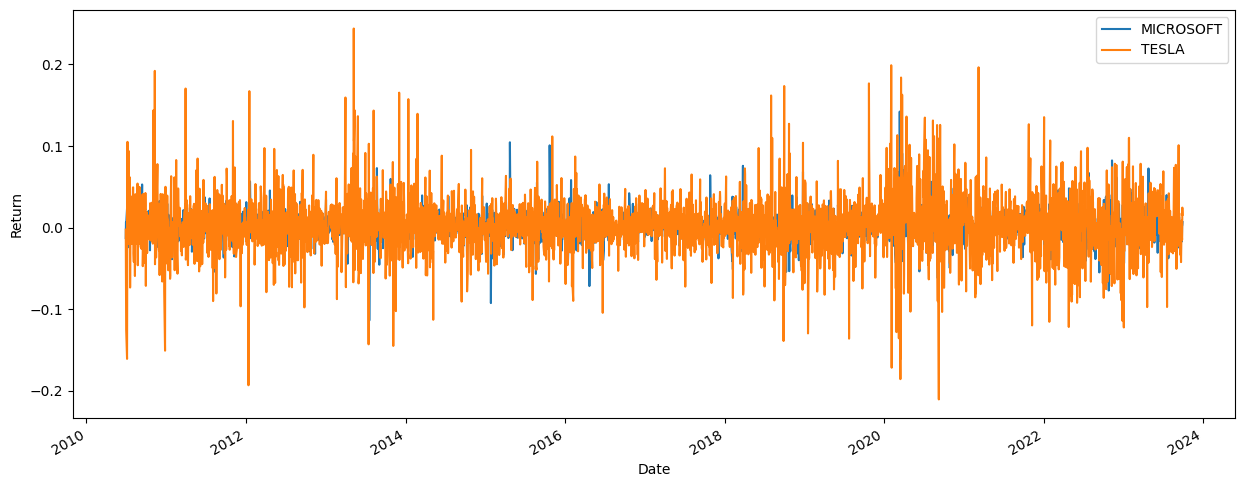

In [24]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `microsoft` and `tesla`
microsoft.plot(ax=ax, label="MICROSOFT")
tesla.plot(ax=ax, label="TESLA")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

Text(0.5, 1.0, 'Distribution of Microsoft Daily Returns')

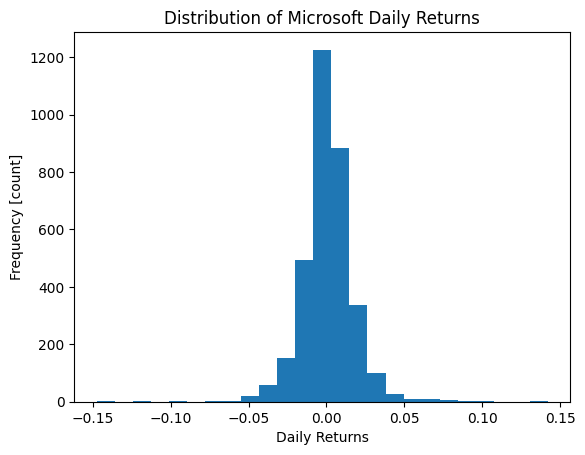

In [26]:
# Create histogram of `MICROSOFT`, 25 bins
plt.hist(microsoft, bins=25)
# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]"),
# Add title
plt.title("Distribution of Microsoft Daily Returns")

Calculate daily volatilities of the two stocks

In [27]:
microsoft_daily_volatility = microsoft.std()
tesla_daily_volatility = tesla.std()

print("Microsoft Daily Volatility:", microsoft_daily_volatility)
print("Tesla Daily Volatility:", tesla_daily_volatility)

Microsoft Daily Volatility: 0.01643143991977089
Tesla Daily Volatility: 0.03597520953516364


Calculate annual volatilities of the two stocks

In [29]:
microsoft_annual_volatility = microsoft_daily_volatility * np.sqrt(252)
tesla_annual_volatility = tesla_daily_volatility * np.sqrt(252)

print("Microsoft Annual Volatility:", microsoft_annual_volatility)
print("Tesla Annual Volatility:", tesla_annual_volatility)

Microsoft Annual Volatility: 0.2608410222624773
Tesla Annual Volatility: 0.5710887467608954


Calculate the rolling volatility for Microsoft, using a 50-day window

In [30]:
microsoft_rolling_50d_volatility = microsoft.rolling(window=50).std().dropna()

print("rolling_50d_volatility type:", type(microsoft_rolling_50d_volatility))
print("rolling_50d_volatility shape:", microsoft_rolling_50d_volatility.shape)
microsoft_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (3287,)


Date
2010-09-09    0.012538
2010-09-10    0.012431
2010-09-13    0.014423
2010-09-14    0.014434
2010-09-15    0.014086
Name: MSFT, dtype: float64

Create a time series plot showing the daily returns for Microsoft and the 50-day rolling volatility

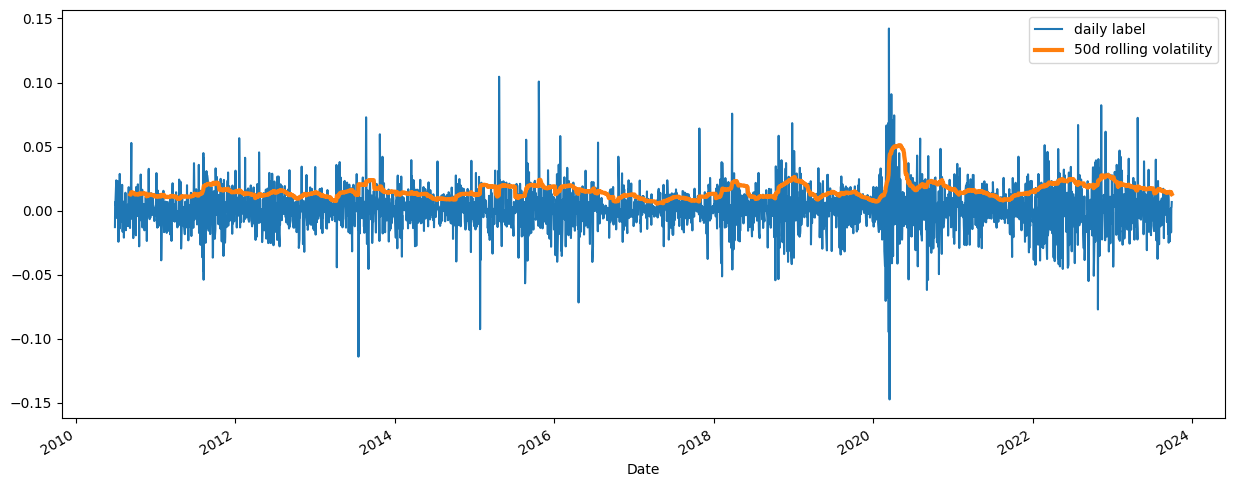

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `microsoft`
microsoft.plot(ax=ax, label="daily label")

# Plot `ambuja_rolling_50d_volatility`
microsoft_rolling_50d_volatility.plot(ax=ax, label="50d rolling volatility",
                                      linewidth=3)

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend();

Here we can see that volatility goes up when the returns change drastically — either up or down. For instance, we can see a big increase in volatility in May 2020, when there were several days of large negative returns. We can also see volatility go down in August 2022, when there are only small day-to-day changes in returns.

This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can be either positive or negative. How can we assess negative and positive numbers together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what we do to calculate performance metrics like mean absolute error. The other solution, which is more common in this context, is to square all the values.

**Create a time series plot of the squared returns in Microsoft.**

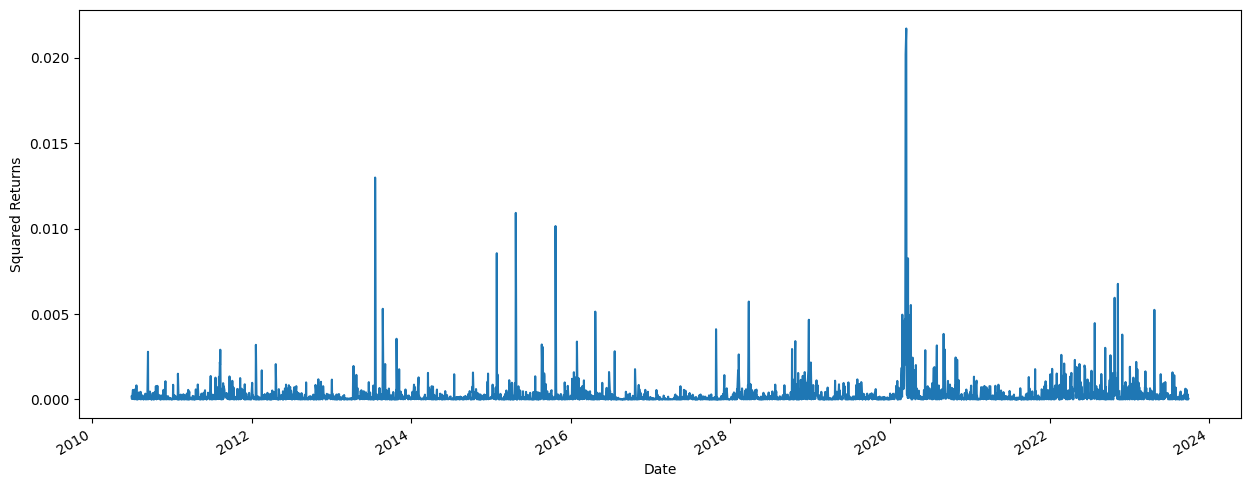

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(microsoft**2).plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

Perfect! Now it's much easier to see that (1) we have periods of high and low volatility, and (2) high volatility days tend to cluster together. This is a perfect situation to use a GARCH model.

A GARCH model is sort of like the ARMA model. It has a p parameter handling correlations at prior time steps and a q parameter for dealing with "shock" events. It also uses the notion of lag. To see how many lags we should have in our model, we should create an ACF and PACF plot — but using the squared returns

**Create an ACF plot of squared returns for Microsoft**

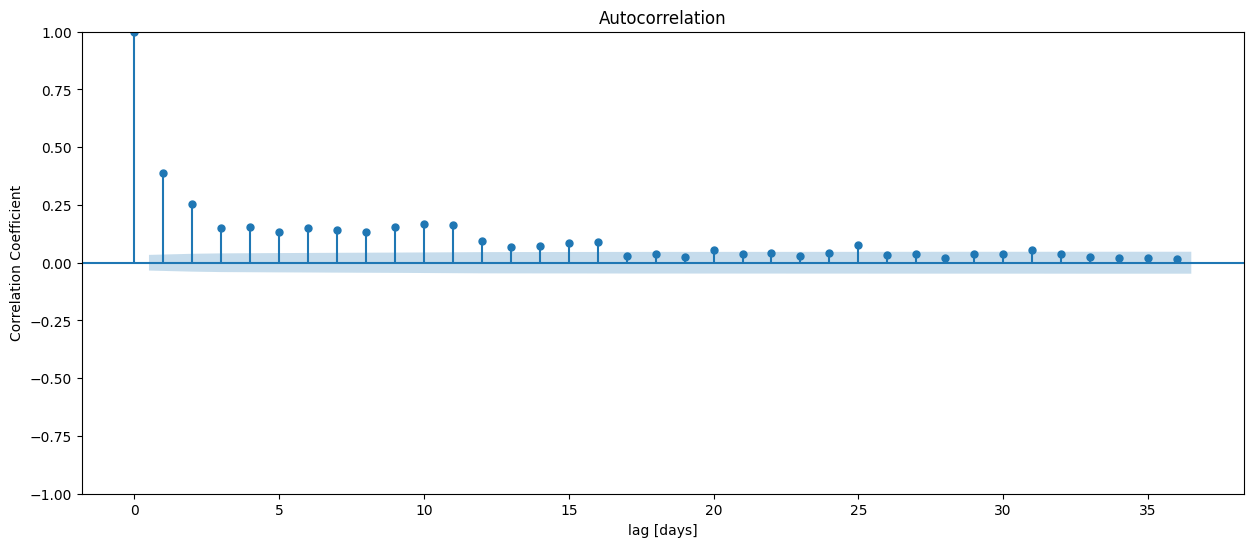

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(microsoft**2, ax=ax)

# Add axis labels
plt.xlabel("lag [days]")
plt.ylabel("Correlation Coefficient");

**Create a PACF plot of squared returns for Microsoft**

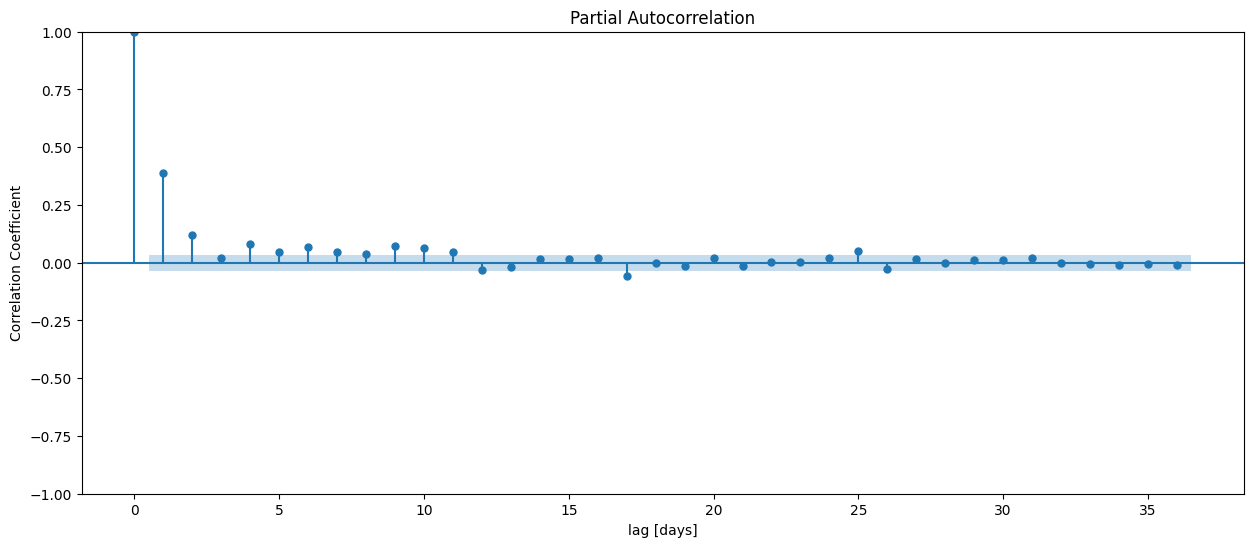

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(microsoft**2, ax=ax)

# Add axis labels
plt.xlabel("lag [days]")
plt.ylabel("Correlation Coefficient");

**Split**

The last thing we need to do before building our model is to create a training set. Note that we won't create a test set here. Rather, we'll use all of microsoft to conduct walk-forward validation after we've built our model.

In [35]:
cutoff_test = int(len(microsoft) * 0.8)
microsoft_train = microsoft.iloc[:cutoff_test]

print("microsoft_train type:", type(microsoft_train))
print("microsoft_train shape:", microsoft_train.shape)
microsoft_train.tail()

microsoft_train type: <class 'pandas.core.series.Series'>
microsoft_train shape: (2668,)


Date
2021-01-28    0.025891
2021-01-29   -0.029172
2021-02-01    0.033152
2021-02-02   -0.000584
2021-02-03    0.014571
Name: MSFT, dtype: float64

**Build Model**

ARCH stands for autoregressive conditionally heteroscedastic, which models the variance of a time series. ARCH model assumes variance at time  𝑡
  depends on the past squared observations. A GARCH (generalized autoregressive conditionally heteroscedastic) model uses values of the past squared observations and past variances to model the variance at time  𝑡
 . ARCH and GARCH models are widely used in finance and econometric time series analysis.

In [36]:
# Build and train model
model = arch_model(
    microsoft_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7500.87
Distribution:                  Normal   AIC:                          -14993.7
Method:            Maximum Likelihood   BIC:                          -14970.2
                                        No. Observations:                 2668
Date:                Sun, Oct 01 2023   Df Residuals:                     2667
Time:                        10:55:30   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3711e-03  2.714e-04      5.052  4.369e-07 [8.392e-04,1.903e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5741e-05  7.036e-07     36.583 5.411e-293 [2.436e-05,2.712e-05]
alpha[1]       0.2000  4.326e-02      4.623  3.780e-06     [  0.115,  0.285]
beta[1]        0.7000  3.276e-02     21.365 2.806e-101     [  0.636,  0.764]
============================================================================

Covariance estimator: robust
"""

In [37]:
#conditional volatility
model.conditional_volatility

Date
2010-06-30    0.013880
2010-07-01    0.014183
2010-07-02    0.013109
2010-07-06    0.012179
2010-07-07    0.015123
                ...   
2021-01-28    0.013399
2021-01-29    0.016482
2021-02-01    0.020062
2021-02-02    0.022572
2021-02-03    0.019574
Name: cond_vol, Length: 2668, dtype: float64

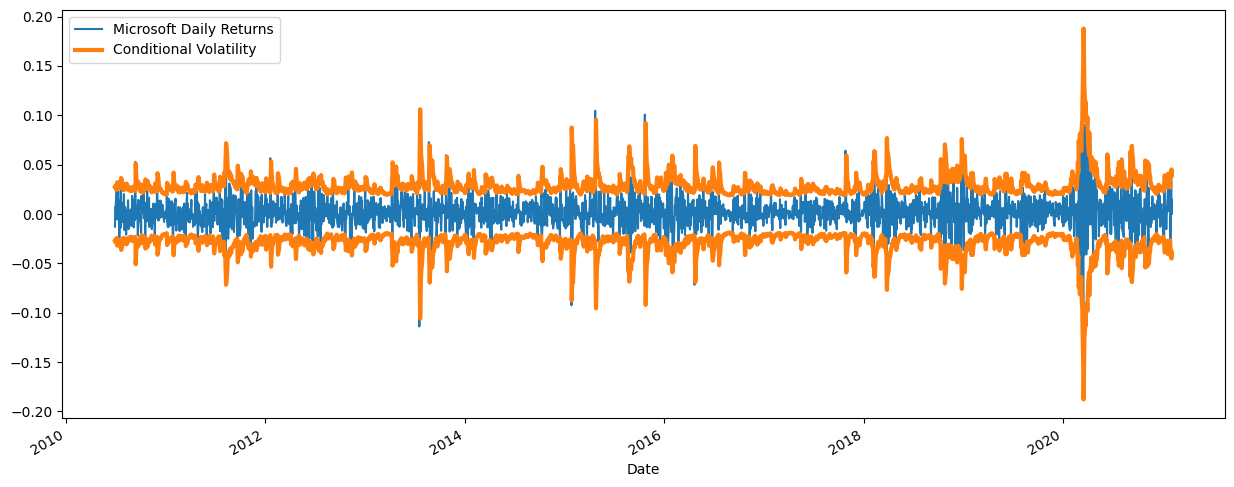

In [38]:
#Create a time series plot of returns and the conditional volatility
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `microsoft_train`
microsoft_train.plot(ax=ax, label="Microsoft Daily Returns")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax, color="C1", label="Conditional Volatility", linewidth=3
)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(
    ax=ax, color="C1", linewidth=3
)


# Add axis labels

plt.xlabel("Date")

# Add legend
plt.legend();

Visually, our model looks pretty good, but we should examine residuals, just to make sure. In the case of GARCH models, we need to look at the standardized residuals.

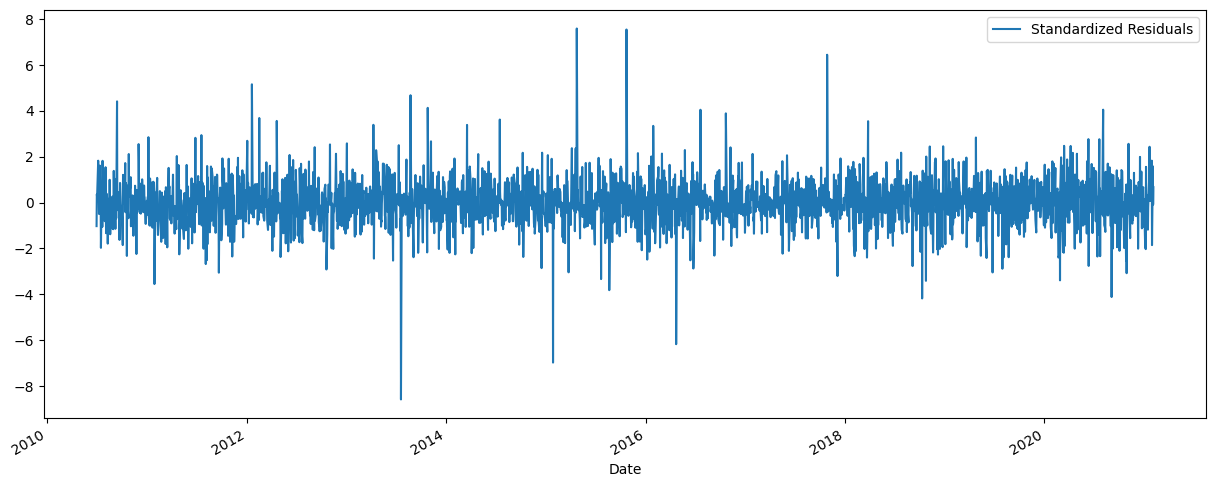

In [39]:
#Create a time series plot of the standardized residuals
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")
# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();



These residuals look good: they have a consistent mean and spread over time. Let's check their normality using a histogram

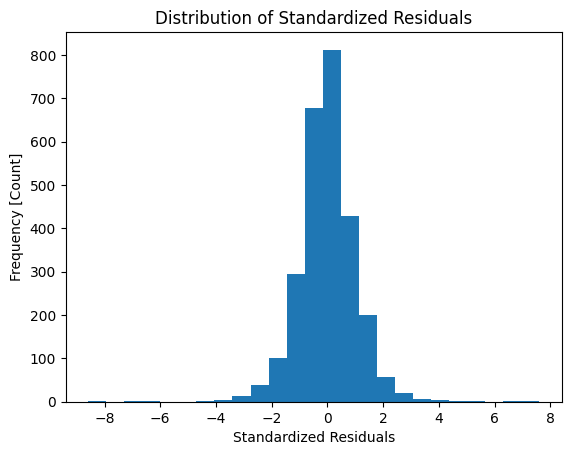

In [40]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid, bins=25)

# Add axis labels

plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency [Count]")
# Add title
plt.title("Distribution of Standardized Residuals");

Our last visualization will the ACF of standardized residuals. Just like we did with our first ACF, we'll need to square the values here, too

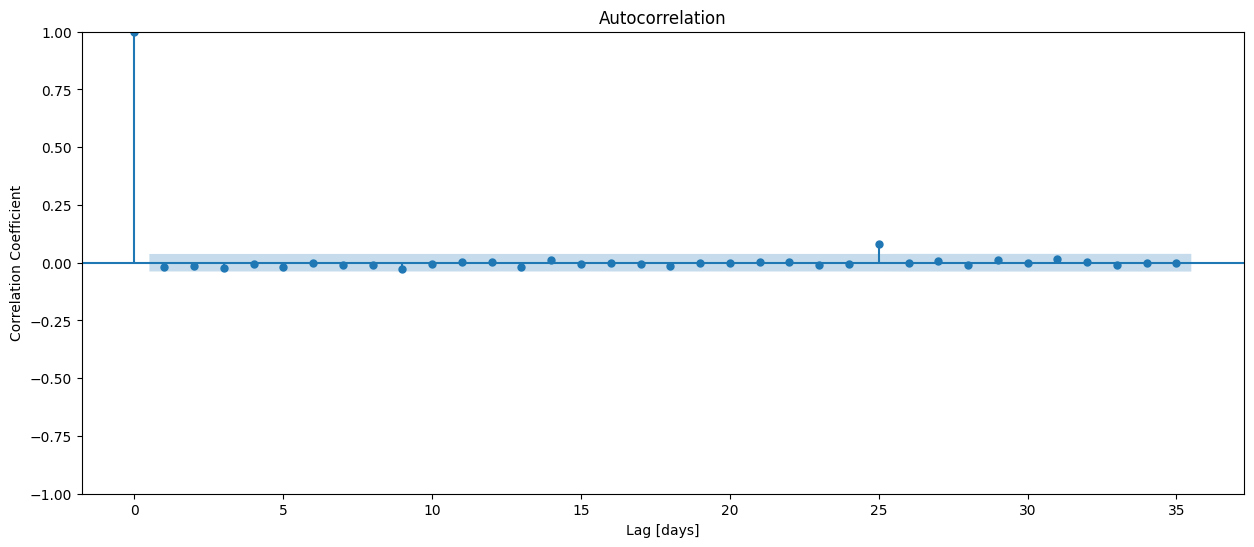

In [41]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

**Evaluate**

In [42]:
#Create a one-day forecast from your model
one_day_forecast = model.forecast(horizon=1, reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
Date,
2021-02-03,0.000329


There are two things we need to keep in mind here. First, our model forecast shows the predicted variance, not the standard deviation / volatility. So we'll need to take the square root of the value. Second, the prediction is in the form of a DataFrame. It has a DatetimeIndex, and the date is the last day for which we have training data. The "h.1" column stands for "horizon 1", that is, our model's prediction for the following day.

walk-forward validation

In [43]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(microsoft) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = microsoft.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=microsoft.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (667,)


Date
2021-02-05    0.016180
2021-02-08    0.014458
2021-02-09    0.013116
2021-02-10    0.012218
2021-02-11    0.011650
dtype: float64

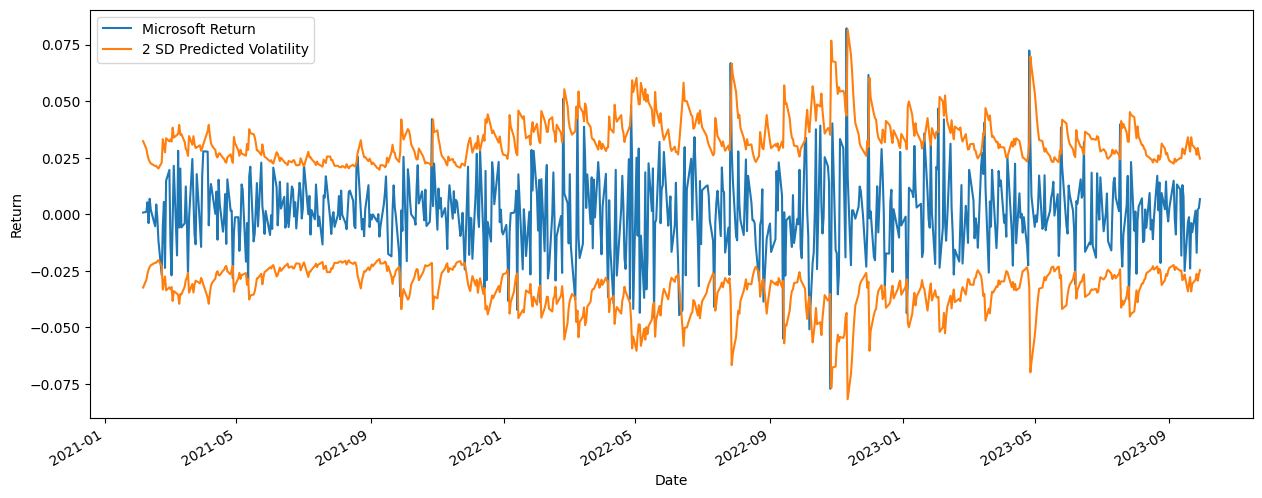

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
microsoft.tail(test_size).plot(ax=ax, label="Microsoft Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

In [45]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2023-09-28  0.012325  0.012795  0.013204  0.013561  0.013875
